In [1]:
import pandas as pd
import os
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

from datetime import datetime
import time

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score, f1_score, recall_score, precision_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def get_model_metrics(test_data, model, model_name):
    """
    Evaluates a binary classification model on test data and reports various performance metrics.
    It calculates the confusion matrix, ROC curve, and several statistical measures including accuracy, 
    sensitivity, specificity, precision, NPV (Negative Predictive Value), PLR (Positive Likelihood Ratio), 
    NLR (Negative Likelihood Ratio), and F1-score. Additionally, it identifies the best threshold for 
    classification based on the max sensitivity within a minimum required specificity.

    The function saves the confusion matrix and ROC curve plots in a local directory, and appends the 
    calculated metrics to a CSV file. This file is created if it doesn't exist, or updated if it does.

    Parameters:
    - test_data (iterable): The test dataset, typically a generator or an iterable that yields batches 
      of images and labels.
    - model (keras.Model): The trained Keras model to evaluate.
    - model_name (str): The name of the model, used for saving output files.

    No return value. The function directly prints the calculated metrics and saves the results and plots 
    to the local file system.
    """
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    results_folder = 'results'
    csv_file = f'{results_folder}/model_performance.csv'
    
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    predicted_probs = model.predict_proba(test_data[0])
    predicted_probs = predicted_probs[:, 1]
    true_labels = test_data[1]
    predicted_labels = model.predict(test_data[0])

    # ROC AUC
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)
    
    # Calculate max sensitivity where specificity is >= 1 - prevalence
    prevalence = sum(true_labels) / len(true_labels)
    
    max_sensitivity = 0
    for i in range(len(fpr)):
        specificity = 1 - fpr[i]
        if specificity >= 1 - prevalence:
            max_sensitivity = max(max_sensitivity, tpr[i])
    print(f"Max Sensitivity at Specificity >= {1 - prevalence:.2f}: {max_sensitivity:.2f}")
    
    # Confusion Matrix
    threshold_for_max_sensitivity = thresholds[np.argmax(tpr == max_sensitivity)]
    final_predicted_labels = [1 if p > threshold_for_max_sensitivity else 0 for p in predicted_probs]
    
    # Confusion Matrix
    confusion_mtx = confusion_matrix(true_labels, final_predicted_labels)
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Purples",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_confusion_matrix.png')
    plt.show()
    
    # Classification report
    report = classification_report(true_labels, final_predicted_labels)
    print(report)

    # calculate additional metrics
    TP = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 1))
    TN = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 0))
    FP = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 1))
    FN = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 0))

    accuracy = accuracy_score(true_labels, final_predicted_labels)
    sensitivity = recall_score(true_labels, final_predicted_labels)  # recall
    specificity = TN / (TN + FP)
    precision = precision_score(true_labels, final_predicted_labels)  # PPV
    npv = TN / (TN + FN)
    plr = sensitivity / (1 - specificity)
    nlr = (1 - sensitivity) / specificity
    f1_pos_class = f1_score(true_labels, final_predicted_labels)

    # ROC AUC
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)
    
    # create a DataFrame and append to the CSV file
    df = pd.DataFrame({
        'Model Name': [model_name],
        f'Max Sensitivity at Specificity {1 - prevalence:.2f}': [max_sensitivity],
        'AUC': [roc_auc],
        'F1-Score Positive Class': [f1_pos_class],
        'Accuracy': [accuracy],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'PPV': [precision],
        'NPV': [npv],
        'PLR': [plr],
        'NLR': [nlr]
    }).round(2) 
    
    if os.path.exists(csv_file):
        df.to_csv(csv_file, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_file, index=False)

    print(df)

    # plotting and saving ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_roc_curve.png')
    plt.show()

In [3]:
# Set the path to your data folders
data_folder = "../../../Data/PESO/cropped_images"
train_folder = os.path.join(data_folder, "cropped_train")
test_folder = os.path.join(data_folder, "cropped_test")
validation_folder = os.path.join(data_folder, "cropped_validation")

## IMAGE AUGMENTATION

In [4]:
from imgaug import augmenters as iaa

In [5]:
# less aggressive image aug
aug = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip with 50% probability
    iaa.Flipud(0.5),  # Vertical flip with 50% probability
    iaa.Multiply((0.8, 1.2)),  # Random brightness adjustment
    iaa.LinearContrast((0.8, 1.2)),  # Random contrast adjustment
])

In [6]:
def augment_images(images):
    # Convert to numpy arrays if they are in a different format
    images_np = np.array(images)
    images_aug = aug.augment_images(images_np)
    return images_aug

## Extract GLCM features

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
def extract_features(image_path):
    image = cv2.imread(image_path, 0)  # Read the image in grayscale
    if image is None or image.size == 0:
        raise ValueError(f"Image at {image_path} could not be loaded")

    resized_img = cv2.resize(image, (128, 64))
    
    props = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']
    features = []

    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    glcm = graycomatrix(resized_img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    for prop in props:
        glcm_prop = graycoprops(glcm, prop)
        features.extend(glcm_prop.flatten())

    return features

def extract_features_train(image):
    resized_img = cv2.resize(image, (128, 64))
    
    props = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']
    features = []

    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    glcm = graycomatrix(resized_img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    for prop in props:
        glcm_prop = graycoprops(glcm, prop)
        features.extend(glcm_prop.flatten())

    return features

def normalize_features(features):
    scaler = StandardScaler()
    return scaler.fit_transform(features)

def load_data(folder):
    data = []
    labels = []

    for subfolder in os.listdir(folder):
        if subfolder != '.DS_Store':
            subfolder_path = os.path.join(folder, subfolder)
            for image_file in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_file)
                try:
                    features = extract_features(image_path)
                    data.append(features)
                    labels.append(subfolder)
                except Exception as e:
                    print(f"Error processing file {image_path}: {e}")
                    continue

    normalized_data = normalize_features(np.array(data))
    return normalized_data, labels

def load_data_train(folder, augmentations_per_image=1):
    data = []
    labels = []

    for subfolder in os.listdir(folder):
        if subfolder != '.DS_Store':
            subfolder_path = os.path.join(folder, subfolder)
            for image_file in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_file)
                try:
                    image = cv2.imread(image_path, 0)
                    if image is None or image.size == 0:
                        continue

                    original_features = extract_features_train(image)
                    data.append(original_features)
                    labels.append(subfolder)

                    for _ in range(augmentations_per_image):
                        image_aug = aug.augment_image(image)
                        augmented_features = extract_features_train(image_aug)
                        data.append(augmented_features)
                        labels.append(subfolder)

                except Exception as e:
                    print(f"Error processing file {image_path}: {e}")
                    continue

    return np.array(data), labels

# With Image Augmentation applied

In [9]:
X_train, y_train = load_data_train(train_folder, augmentations_per_image=3)
X_validation, y_validation = load_data(validation_folder)
X_test, y_test = load_data(test_folder)

In [10]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform your string labels to numerical labels
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)
y_validation = label_encoder.fit_transform(y_validation)

In [11]:
# Merge X_test and X_validation
X_test = np.vstack((X_test, X_validation))
y_test = np.concatenate((y_test, y_validation))

In [12]:
# save data to upload to colab for later model tuning
np.savetxt("X_train_PESO.csv", X_train, delimiter=",")
np.savetxt("X_test_PESO.csv", X_test, delimiter=",")
np.savetxt("y_train_PESO.csv", y_train, delimiter=",")
np.savetxt("y_test_PESO.csv", y_test, delimiter=",")

In [13]:
# Extract class weights
from sklearn.utils.class_weight import compute_class_weight

# Convert the labels to a NumPy array
labels = np.array(y_train)

total_samples = len(labels)
class_labels, class_counts = np.unique(labels, return_counts=True)
#class_weights = total_samples / (len(class_labels) * class_counts)
class_weights = [1 - class_counts[0] / total_samples, 1 - class_counts[1] / total_samples]

# Create a dictionary for class weights
class_weights_dict = dict(zip(class_labels, class_weights))

#new_labels = {'healthy': 0, 'unhealthy': 1}

# Create a new dictionary with the renamed keys
#class_weights = {new_labels[key]: value for key, value in class_weights_dict.items()}

In [14]:
class_weights_dict

{0: 0.16216216216216217, 1: 0.8378378378378378}

In [15]:
sample_weights = [class_weights[label] for label in y_train]

## SVC

In [16]:
# Train a classifier (SVM in this case)
classifier = SVC(kernel='linear', C=1.0, random_state=42, probability=True, class_weight=class_weights_dict)
classifier.fit(X_train, y_train)

SVC(class_weight={0: 0.16216216216216217, 1: 0.8378378378378378},
    kernel='linear', probability=True, random_state=42)

Max Sensitivity at Specificity >= 0.84: 0.09


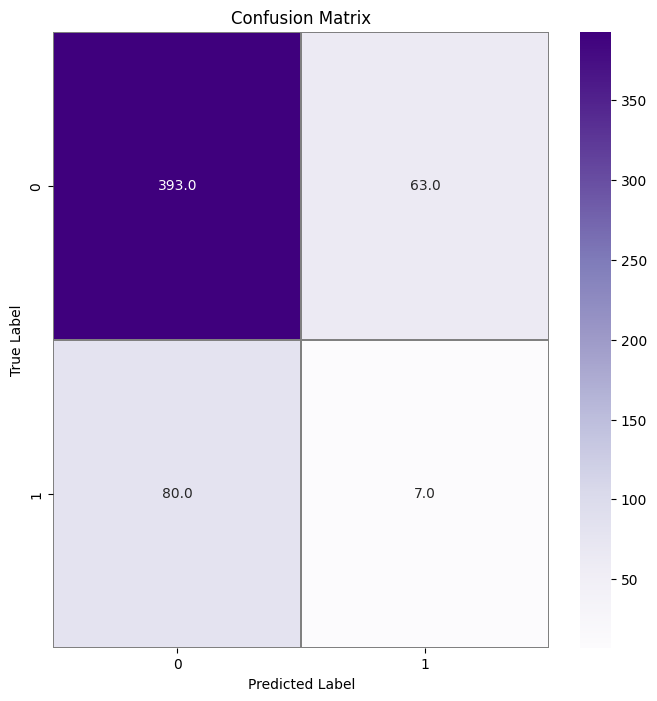

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       456
           1       0.10      0.08      0.09        87

    accuracy                           0.74       543
   macro avg       0.47      0.47      0.47       543
weighted avg       0.71      0.74      0.72       543

    Model Name  Max Sensitivity at Specificity 0.84   AUC   
0  LBW-SVC-AUG                                 0.09  0.44  \

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity  PPV   NPV   
0                     0.09      0.74         0.08         0.86  0.1  0.83  \

    PLR   NLR  
0  0.58  1.07  


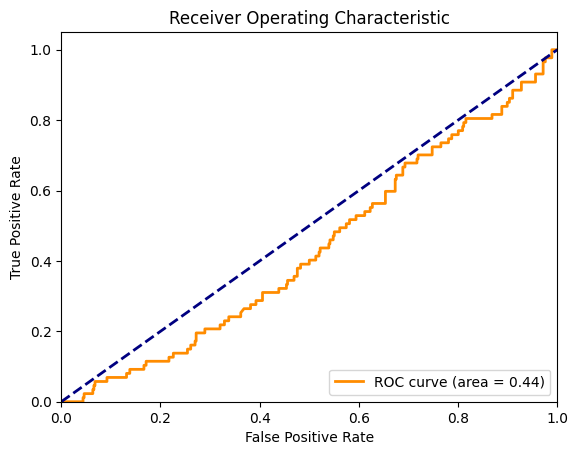

In [17]:
get_model_metrics(test_data=[X_test,y_test], model=classifier, model_name='LBW-SVC-AUG')

In [18]:
# no class weights
classifier = SVC(kernel='linear', C=1.0, random_state=42, probability=True)
classifier.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

Max Sensitivity at Specificity >= 0.84: 0.15


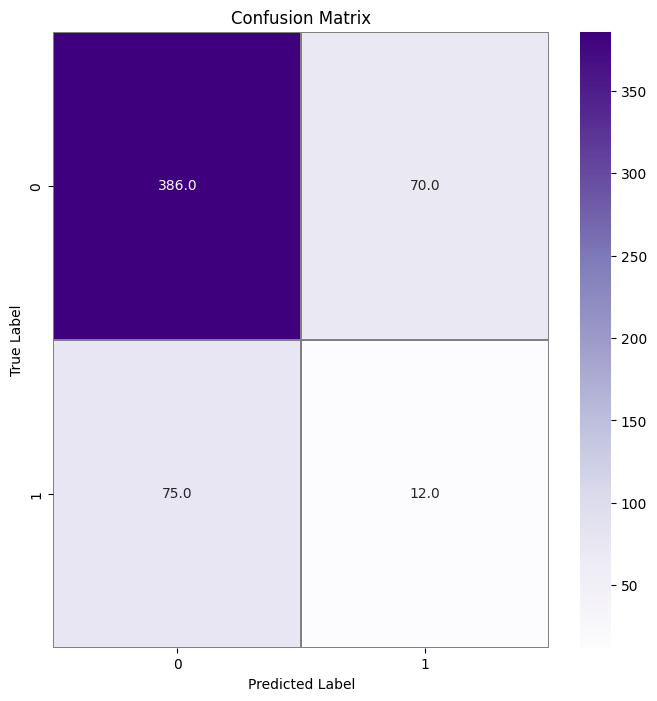

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       456
           1       0.15      0.14      0.14        87

    accuracy                           0.73       543
   macro avg       0.49      0.49      0.49       543
weighted avg       0.73      0.73      0.73       543

          Model Name  Max Sensitivity at Specificity 0.84   AUC   
0  LBW-SVC-AUG-no-CW                                 0.15  0.46  \

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV   
0                     0.14      0.73         0.14         0.85  0.15  0.84  \

   PLR   NLR  
0  0.9  1.02  


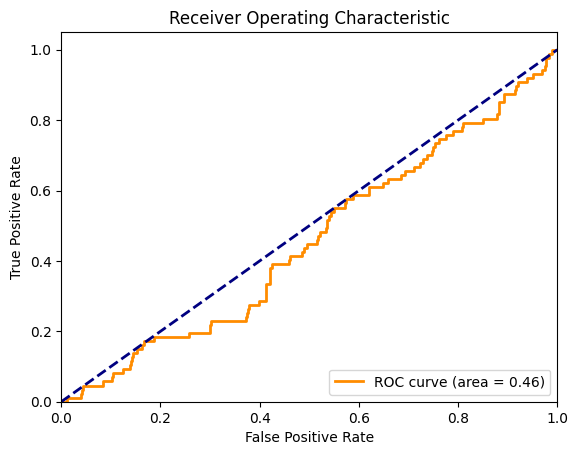

In [19]:
get_model_metrics(test_data=[X_test,y_test], model=classifier, model_name='LBW-SVC-AUG-no-CW')

## LOGISTIC REGRESSION

In [20]:
classifier = LogisticRegression(random_state=42, class_weight=class_weights_dict)
classifier.fit(X_train, y_train)

/Users/gcarballido/opt/miniconda3/envs/deeplearning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={0: 0.16216216216216217, 1: 0.8378378378378378},
                   random_state=42)

Max Sensitivity at Specificity >= 0.84: 0.08


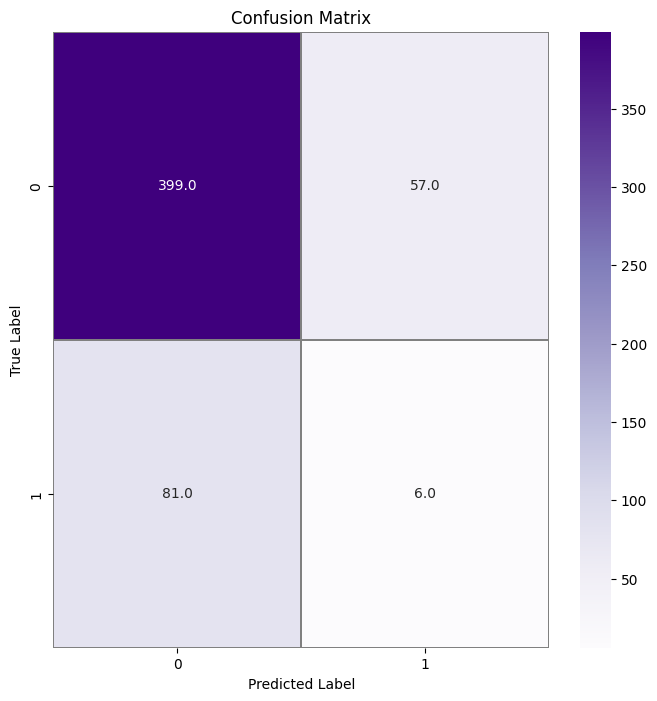

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       456
           1       0.10      0.07      0.08        87

    accuracy                           0.75       543
   macro avg       0.46      0.47      0.47       543
weighted avg       0.71      0.75      0.73       543

   Model Name  Max Sensitivity at Specificity 0.84   AUC   
0  LBW-LR-AUG                                 0.08  0.43  \

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity  PPV   NPV   
0                     0.08      0.75         0.07         0.88  0.1  0.83  \

    PLR   NLR  
0  0.55  1.06  


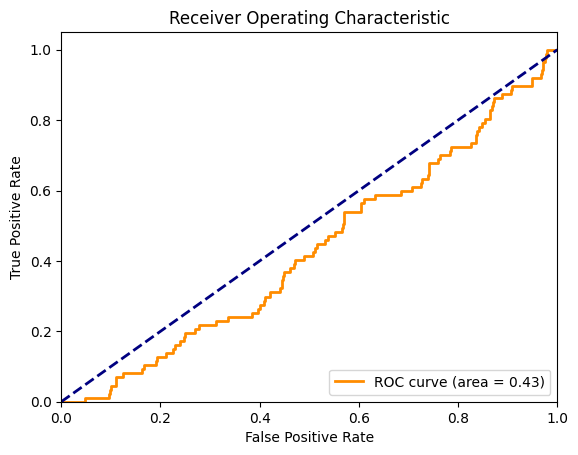

In [21]:
get_model_metrics(test_data=[X_test,y_test], model=classifier, model_name='LBW-LR-AUG')

In [22]:
# no class weights
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)

/Users/gcarballido/opt/miniconda3/envs/deeplearning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

Max Sensitivity at Specificity >= 0.84: 0.11


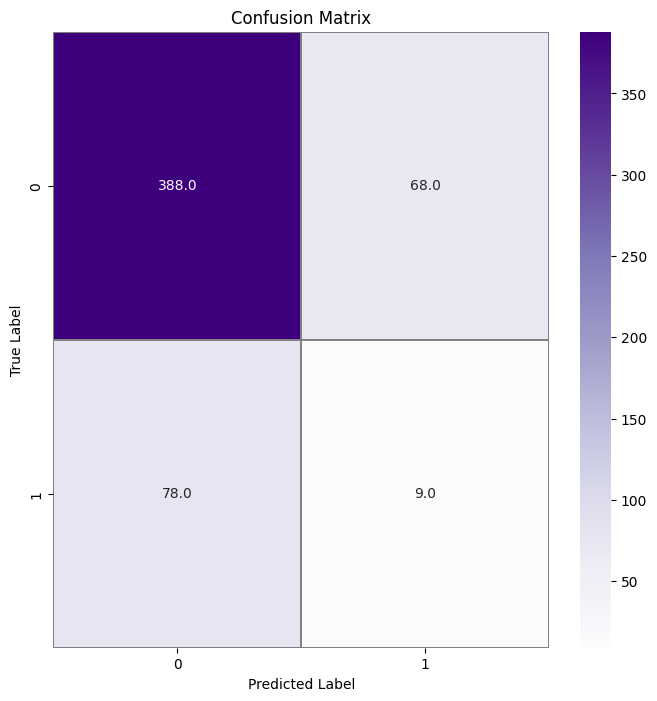

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       456
           1       0.12      0.10      0.11        87

    accuracy                           0.73       543
   macro avg       0.47      0.48      0.48       543
weighted avg       0.72      0.73      0.72       543

         Model Name  Max Sensitivity at Specificity 0.84   AUC   
0  LBW-LR-AUG-no-CW                                 0.11  0.48  \

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV   
0                     0.11      0.73          0.1         0.85  0.12  0.83  \

    PLR   NLR  
0  0.69  1.05  


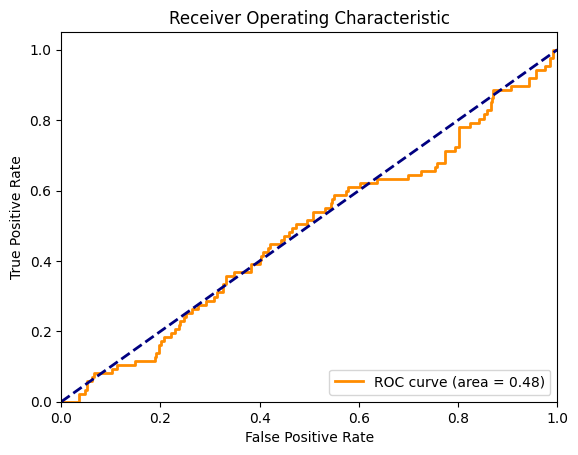

In [23]:
get_model_metrics(test_data=[X_test,y_test], model=classifier, model_name='LBW-LR-AUG-no-CW')

# Without Image Augmentation applied

In [24]:
X_train, y_train = load_data(train_folder)
X_validation, y_validation = load_data(validation_folder)
X_test, y_test = load_data(test_folder)

In [25]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform your string labels to numerical labels
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)
y_validation = label_encoder.fit_transform(y_validation)

In [26]:
# Merge X_test and X_validation
X_test = np.vstack((X_test, X_validation))
y_test = np.concatenate((y_test, y_validation))

In [27]:
# save data to upload to colab for later model tuning
np.savetxt("X_train_PESO_noaug.csv", X_train, delimiter=",")
np.savetxt("X_test_PESO_noaug.csv", X_test, delimiter=",")
np.savetxt("y_train_PESO_noaug.csv", y_train, delimiter=",")
np.savetxt("y_test_PESO_noaug.csv", y_test, delimiter=",")

In [28]:
# Extract class weights
from sklearn.utils.class_weight import compute_class_weight

# Convert the labels to a NumPy array
labels = np.array(y_train)

total_samples = len(labels)
class_labels, class_counts = np.unique(labels, return_counts=True)
#class_weights = total_samples / (len(class_labels) * class_counts)
class_weights = [1 - class_counts[0] / total_samples, 1 - class_counts[1] / total_samples]

# Create a dictionary for class weights
class_weights_dict = dict(zip(class_labels, class_weights))

#new_labels = {'healthy': 0, 'unhealthy': 1}

# Create a new dictionary with the renamed keys
#class_weights = {new_labels[key]: value for key, value in class_weights_dict.items()}

In [29]:
class_weights_dict

{0: 0.16216216216216217, 1: 0.8378378378378378}

In [30]:
sample_weights = [class_weights[label] for label in y_train]

## SVC

In [31]:
# Train a classifier (SVM in this case)
classifier = SVC(kernel='linear', C=1.0, random_state=42, probability=True, class_weight=class_weights_dict)
classifier.fit(X_train, y_train)

SVC(class_weight={0: 0.16216216216216217, 1: 0.8378378378378378},
    kernel='linear', probability=True, random_state=42)

Max Sensitivity at Specificity >= 0.84: 0.17


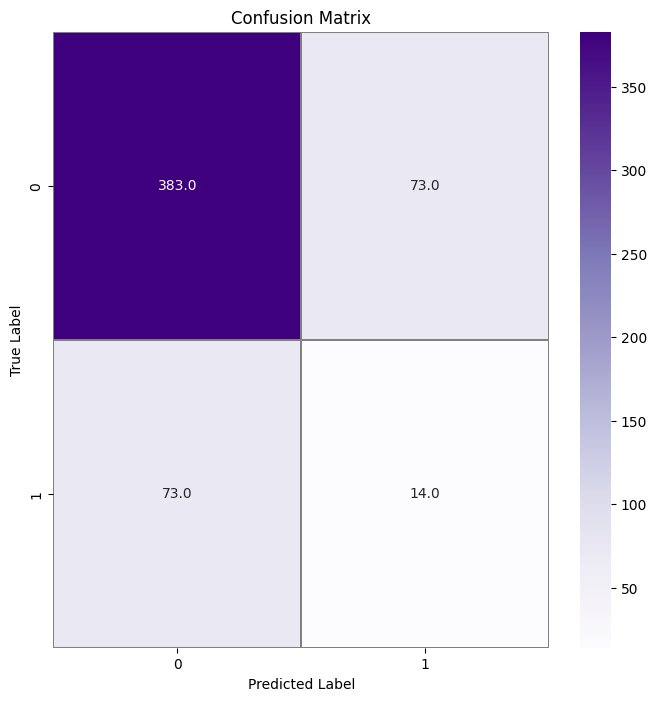

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       456
           1       0.16      0.16      0.16        87

    accuracy                           0.73       543
   macro avg       0.50      0.50      0.50       543
weighted avg       0.73      0.73      0.73       543

       Model Name  Max Sensitivity at Specificity 0.84   AUC   
0  LBW-SVC-no-AUG                                 0.17  0.54  \

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV   
0                     0.16      0.73         0.16         0.84  0.16  0.84  \

    PLR  NLR  
0  1.01  1.0  


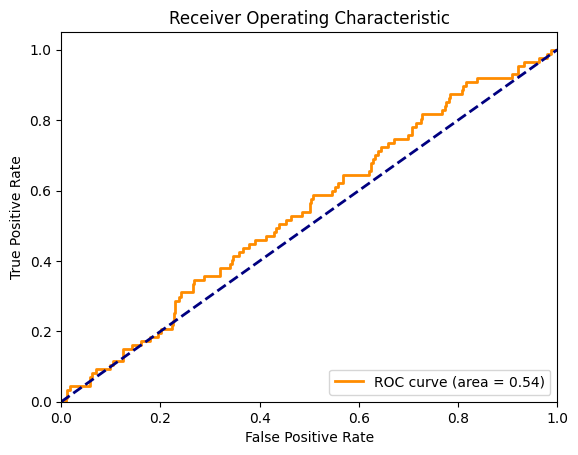

In [32]:
get_model_metrics(test_data=[X_test,y_test], model=classifier, model_name='LBW-SVC-no-AUG')

In [33]:
# no class weights
model_name = 'GLCM_SVC_no_CW_no_img_aug'

classifier = SVC(kernel='linear', C=1.0, random_state=42, probability=True)
classifier.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

Max Sensitivity at Specificity >= 0.84: 0.17


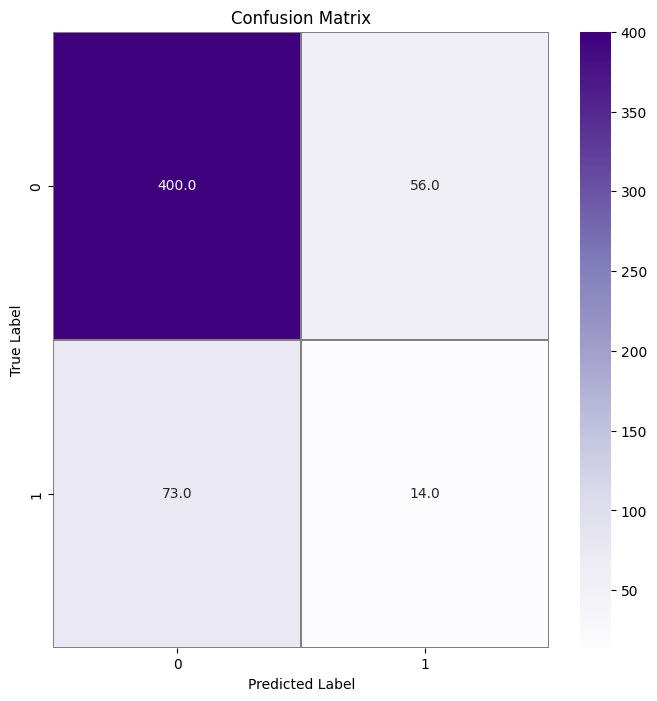

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       456
           1       0.20      0.16      0.18        87

    accuracy                           0.76       543
   macro avg       0.52      0.52      0.52       543
weighted avg       0.74      0.76      0.75       543

             Model Name  Max Sensitivity at Specificity 0.84   AUC   
0  LBW-SVC-no-AUG-no-CW                                 0.17  0.54  \

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity  PPV   NPV   
0                     0.18      0.76         0.16         0.88  0.2  0.85  \

    PLR   NLR  
0  1.31  0.96  


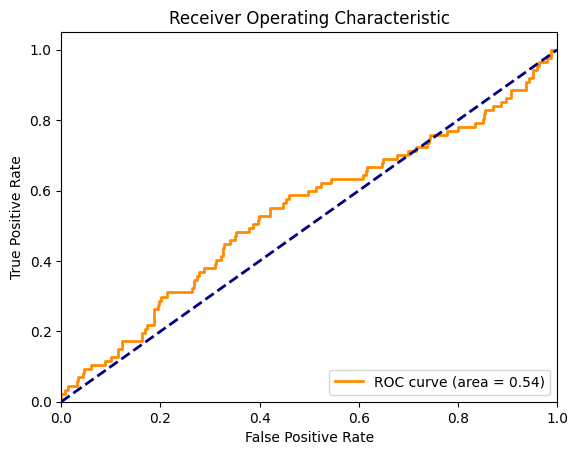

In [34]:
get_model_metrics(test_data=[X_test,y_test], model=classifier, model_name='LBW-SVC-no-AUG-no-CW')

## Logistic Regression

In [35]:
classifier = LogisticRegression(random_state=42, class_weight=class_weights_dict)
classifier.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.16216216216216217, 1: 0.8378378378378378},
                   random_state=42)

Max Sensitivity at Specificity >= 0.84: 0.10


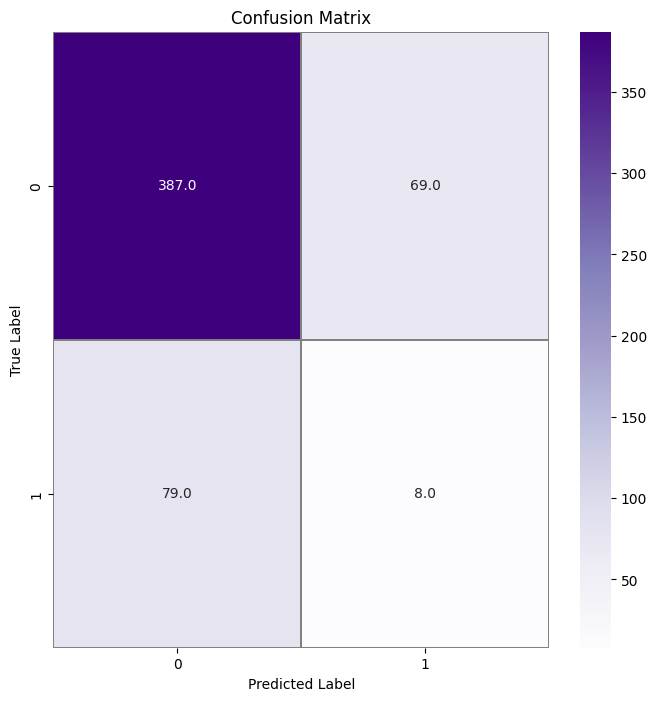

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       456
           1       0.10      0.09      0.10        87

    accuracy                           0.73       543
   macro avg       0.47      0.47      0.47       543
weighted avg       0.71      0.73      0.72       543

      Model Name  Max Sensitivity at Specificity 0.84   AUC   
0  LBW-LR-no-AUG                                  0.1  0.52  \

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity  PPV   NPV   
0                      0.1      0.73         0.09         0.85  0.1  0.83  \

    PLR   NLR  
0  0.61  1.07  


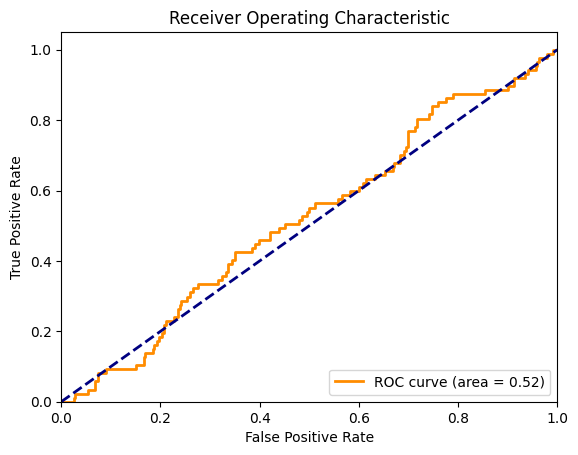

In [36]:
get_model_metrics(test_data=[X_test,y_test], model=classifier, model_name='LBW-LR-no-AUG')

In [37]:
# no class weights
model_name = 'GLCM_LR_no_CW_no_img_aug'

classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=42)

Max Sensitivity at Specificity >= 0.84: 0.16


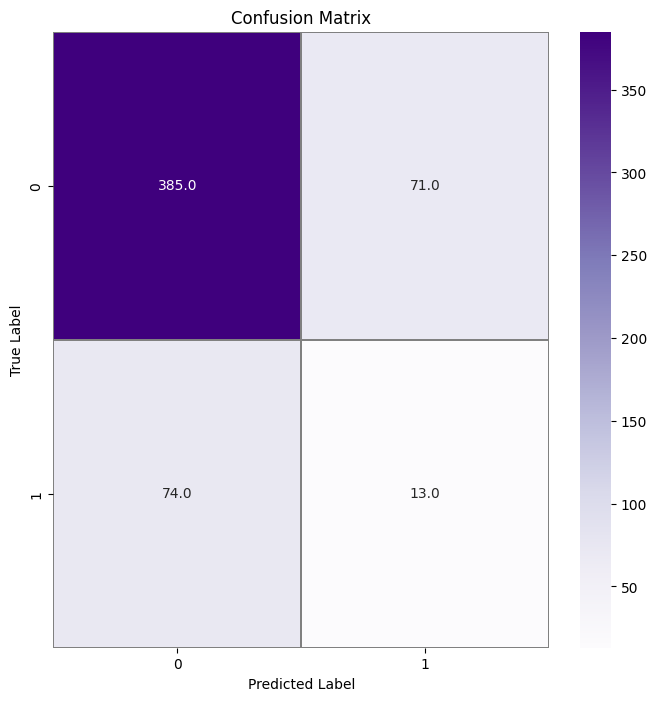

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       456
           1       0.15      0.15      0.15        87

    accuracy                           0.73       543
   macro avg       0.50      0.50      0.50       543
weighted avg       0.73      0.73      0.73       543

            Model Name  Max Sensitivity at Specificity 0.84   AUC   
0  LBW-LR-no-AUG-no-CW                                 0.16  0.53  \

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV   
0                     0.15      0.73         0.15         0.84  0.15  0.84  \

    PLR   NLR  
0  0.96  1.01  


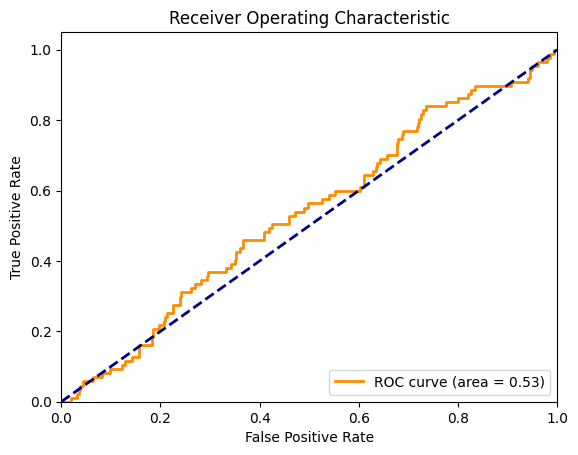

In [38]:
get_model_metrics(test_data=[X_test,y_test], model=classifier, model_name='LBW-LR-no-AUG-no-CW')